# Tutorial for Wasserstein Wormhole

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import umap
import numpy as np
import pandas as pd
import scipy.stats

import matplotlib
import matplotlib.pyplot as plt
import colorcet
import seaborn as sns


import sklearn.metrics
import sklearn.neural_network
import sklearn.neighbors
import skimage.filters

/cv/home/havivd/wfm_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from wassersteinwormhole import Wormhole
from emnist import extract_training_samples, extract_test_samples

## Load MNIST data

In [4]:
# import tensorflow.keras.datasets
# mnist = tensorflow.keras.datasets.mnist

# (image_train, label_train), (image_test, label_test) = mnist.load_data()


image_train, label_train = extract_training_samples('mnist')
image_test, label_test = extract_test_samples('mnist')

image_train, image_test = image_train/255.0, image_test/255.0



In [5]:
pc_train, weight_train = [np.stack(np.where(image>0), axis = 1) for image in image_train], [image[image>0]/image[image>0].sum() for image in image_train]
pc_test, weight_test = [np.stack(np.where(image>0), axis = 1) for image in image_test], [image[image>0]/image[image>0].sum() for image in image_test]


Normalize point-clouds to be between -1 and 1

In [6]:
pc_train = [2 * pc/image_train.shape[-1] - 1 for pc in pc_train]
pc_test = [2 * pc/image_test.shape[-1] - 1 for pc in pc_test]

### Show some examples

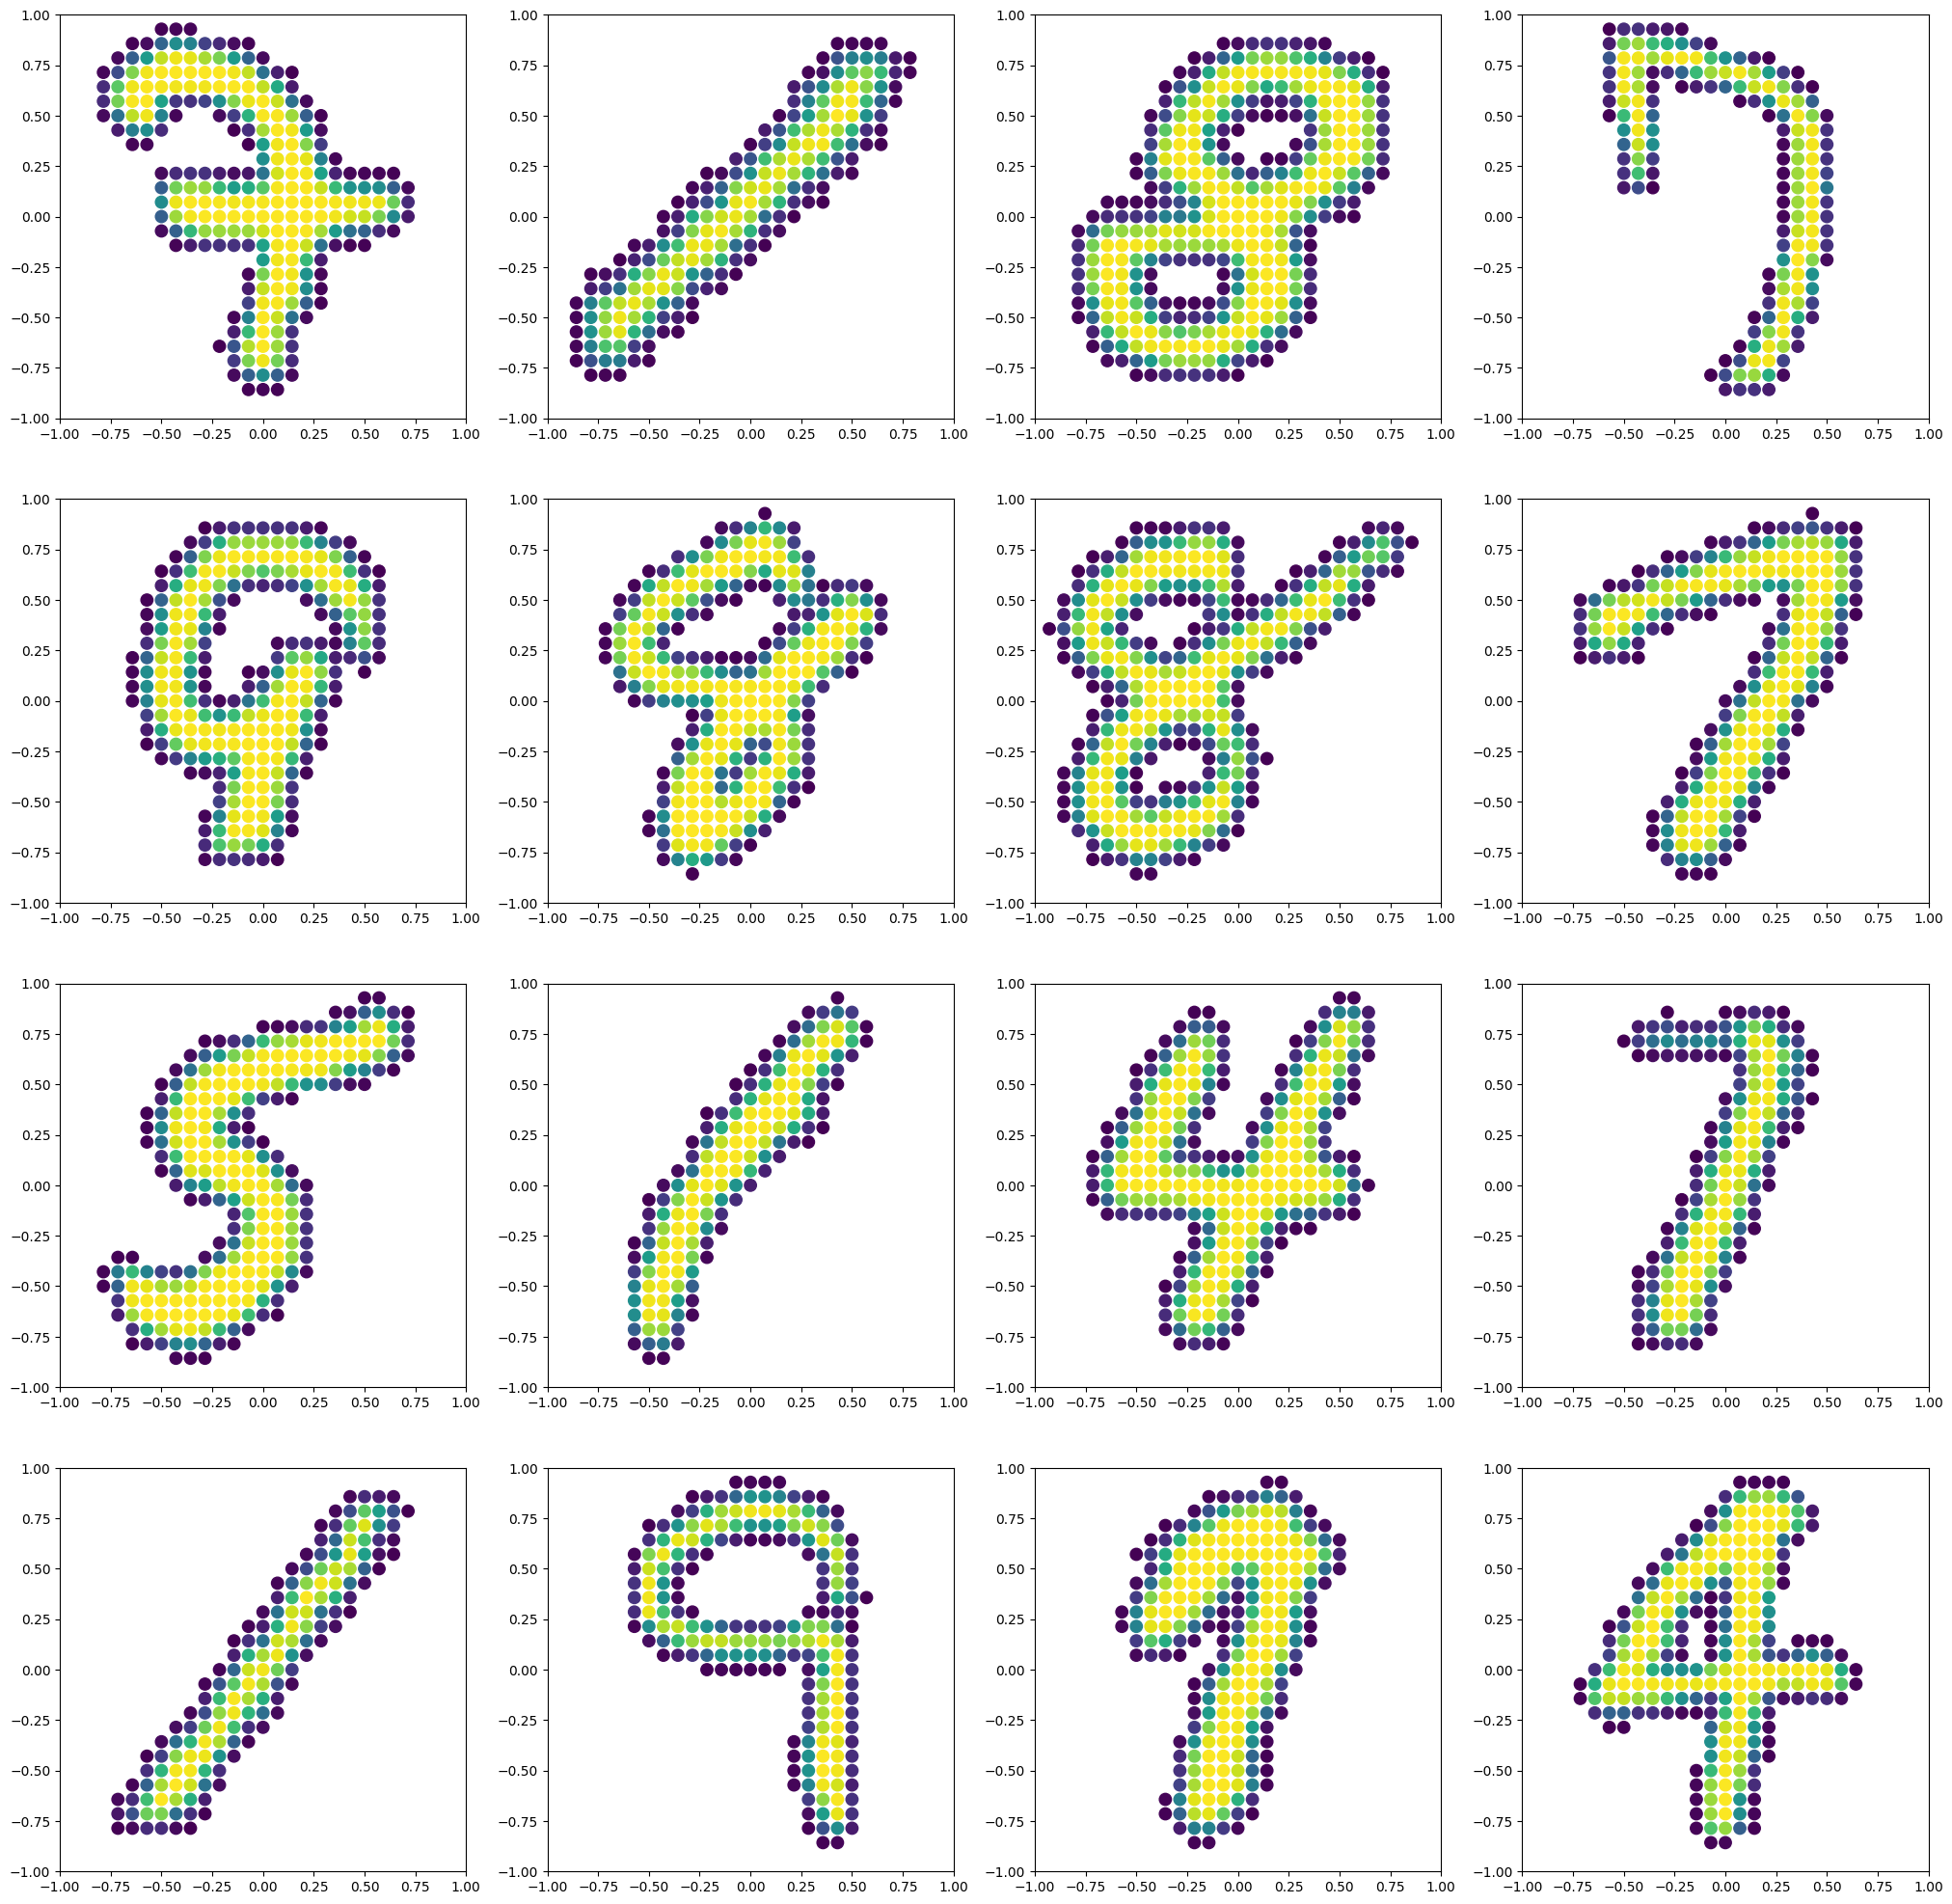

In [7]:
thresh = skimage.filters.threshold_otsu(image_train.reshape([-1]))
fig = plt.figure(figsize = (25,25))
for _ in range(16):
    i = np.random.choice(np.arange(image_train.shape[0]))
    
    plt.subplot(4,4,1+_)
    plt.scatter(pc_train[i][:, 1], -pc_train[i][:, 0], c = weight_train[i], s = 80)
    plt.xlim([-1, 1])
    plt.ylim([-1, 1])
plt.show()

## Or load your own set of point-clouds

In [ ]:
import pickle

with open('/path/to/data/pc_train.pickle', 'rb') as f:
    pc_train = pickle.load(f)

with open('/path/to/data/weight_train.pickle', 'rb') as f:
    weight_train = pickle.load(f)
    
with open('/path/to/data/pc_test.pickle', 'rb') as f:
    pc_test = pickle.load(f)
    
with open('/path/to/data/weight_test.pickle', 'rb') as f:
    weight_test = pickle.load(f)
    
label_train = np.load('/path/to/data/label_train.npy')
label_test = np.load('/path/to/data/label_test.npy')

## Wormhole Model

In [15]:
WormholeModel = Wormhole(point_clouds = pc_train, weights = weight_train, point_clouds_test = pc_test, weights_test = weight_test)

Processing train and test point clouds together to ensure consistent padding
Extracting train point clouds and weights after padding
Train point clouds shape after padding: (60000, 476, 2)
Extracting test point clouds and weights after padding
Test point clouds shape after padding: (10000, 476, 2)
Decoder generating point-clouds of size:  184


Calculating max of max distances (metric: squared Euclidean): 100%|██████████| 1000/1000 [00:01<00:00, 598.02it/s]


Using OT scale value of 5.89e+00
Automatically setting num_sinkhorn_iter by testing OT function
Preparing batch of 100 pairs for S2 convergence check...
Running S2 solver for 5000 iterations on 100 pairs...
95% convergence reached at approx 100 iterations.
Setting num_sinkhorn_iter to 100


### Train model

In [17]:
WormholeModel.train()

 enc_loss: 5.267e-06 dec_loss: 1.775e-04 enc_corr: 0.969: 100%|██████████| 10000/10000 [11:22<00:00, 14.64it/s]


#### Save parameters

In [ ]:
with open('/path/to/savedmodel/WormholeModel.pickle', 'wb') as f:
    pickle.dump(WormholeModel.params, f)

### Or Load trained model

In [ ]:
with open('/path/to/savedmodel/WormholeModel.pickle', 'rb') as f:
    WormholeModel.params = pickle.load(f)

## Generate encodings

In [18]:
train_encodings = WormholeModel.encode(WormholeModel.point_clouds, WormholeModel.weights)
test_encodings = WormholeModel.encode(WormholeModel.point_clouds_test, WormholeModel.weights_test)

Point clouds already in array format for encoding
Point clouds already in array format for encoding


### Compare to true Wasserstein distance

#### Train

In [20]:
train_rand_ind = np.random.choice(np.arange(train_encodings.shape[0]), 128,replace = False)
upper_traingular_ind = np.stack(np.triu_indices(train_rand_ind.shape[0], 1), axis = 1) 

true_w2 = np.asarray(WormholeModel.jit_dist_enc([WormholeModel.point_clouds[train_rand_ind][upper_traingular_ind[:, 0]], 
                                                 WormholeModel.weights[train_rand_ind][upper_traingular_ind[:, 0]]], 
                                                [WormholeModel.point_clouds[train_rand_ind][upper_traingular_ind[:, 1]], 
                                                 WormholeModel.weights[train_rand_ind][upper_traingular_ind[:, 1]]])) 

enc_L2 = np.mean(np.square(train_encodings[train_rand_ind][upper_traingular_ind[:, 0]] - train_encodings[train_rand_ind][upper_traingular_ind[:, 1]]), axis = -1)

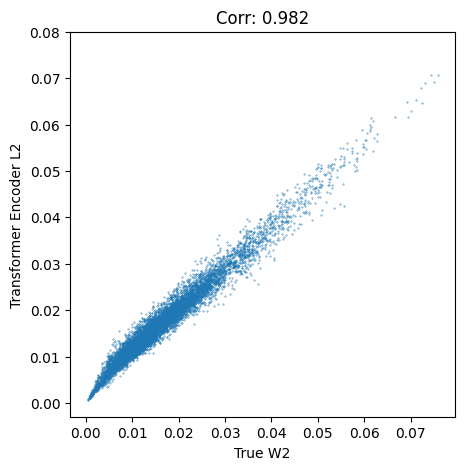

In [21]:
plt.figure(figsize = (5,5))
plt.scatter(true_w2, enc_L2, s = 0.1)
plt.axis('square')
plt.xlabel('True W2')
plt.ylabel('Transformer Encoder L2')
plt.title('Corr: ' + str(np.round(scipy.stats.pearsonr(true_w2, enc_L2)[0],3)))
plt.show()

#### Test

In [22]:
test_rand_ind = np.random.choice(np.arange(test_encodings.shape[0]), 128,replace = False)
upper_traingular_ind = np.stack(np.triu_indices(test_rand_ind.shape[0], 1), axis = 1) 

true_w2 = np.asarray(WormholeModel.jit_dist_enc([WormholeModel.point_clouds_test[test_rand_ind][upper_traingular_ind[:, 0]], 
                                                 WormholeModel.weights_test[test_rand_ind][upper_traingular_ind[:, 0]]], 
                                                [WormholeModel.point_clouds_test[test_rand_ind][upper_traingular_ind[:, 1]], 
                                                 WormholeModel.weights_test[test_rand_ind][upper_traingular_ind[:, 1]]])) 

enc_L2 = np.mean(np.square(test_encodings[test_rand_ind][upper_traingular_ind[:, 0]] - test_encodings[test_rand_ind][upper_traingular_ind[:, 1]]), axis = -1)

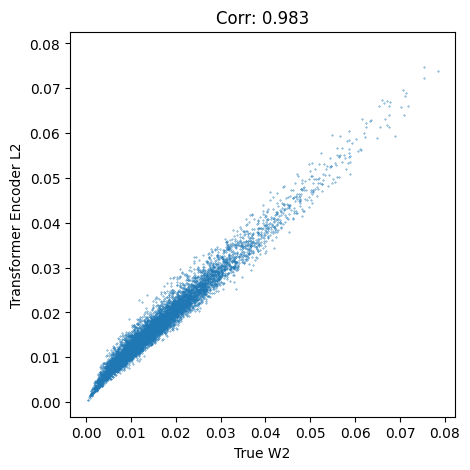

In [23]:
plt.figure(figsize = (5,5))
plt.scatter(true_w2, enc_L2, s = 0.1)
plt.axis('square')
plt.xlabel('True W2')
plt.ylabel('Transformer Encoder L2')
plt.title('Corr: ' + str(np.round(scipy.stats.pearsonr(true_w2, enc_L2)[0],3)))
plt.show()

##  Decodings

In [24]:
train_decodings = WormholeModel.decode(train_encodings)
test_decodings = WormholeModel.decode(test_encodings)

### Plot train

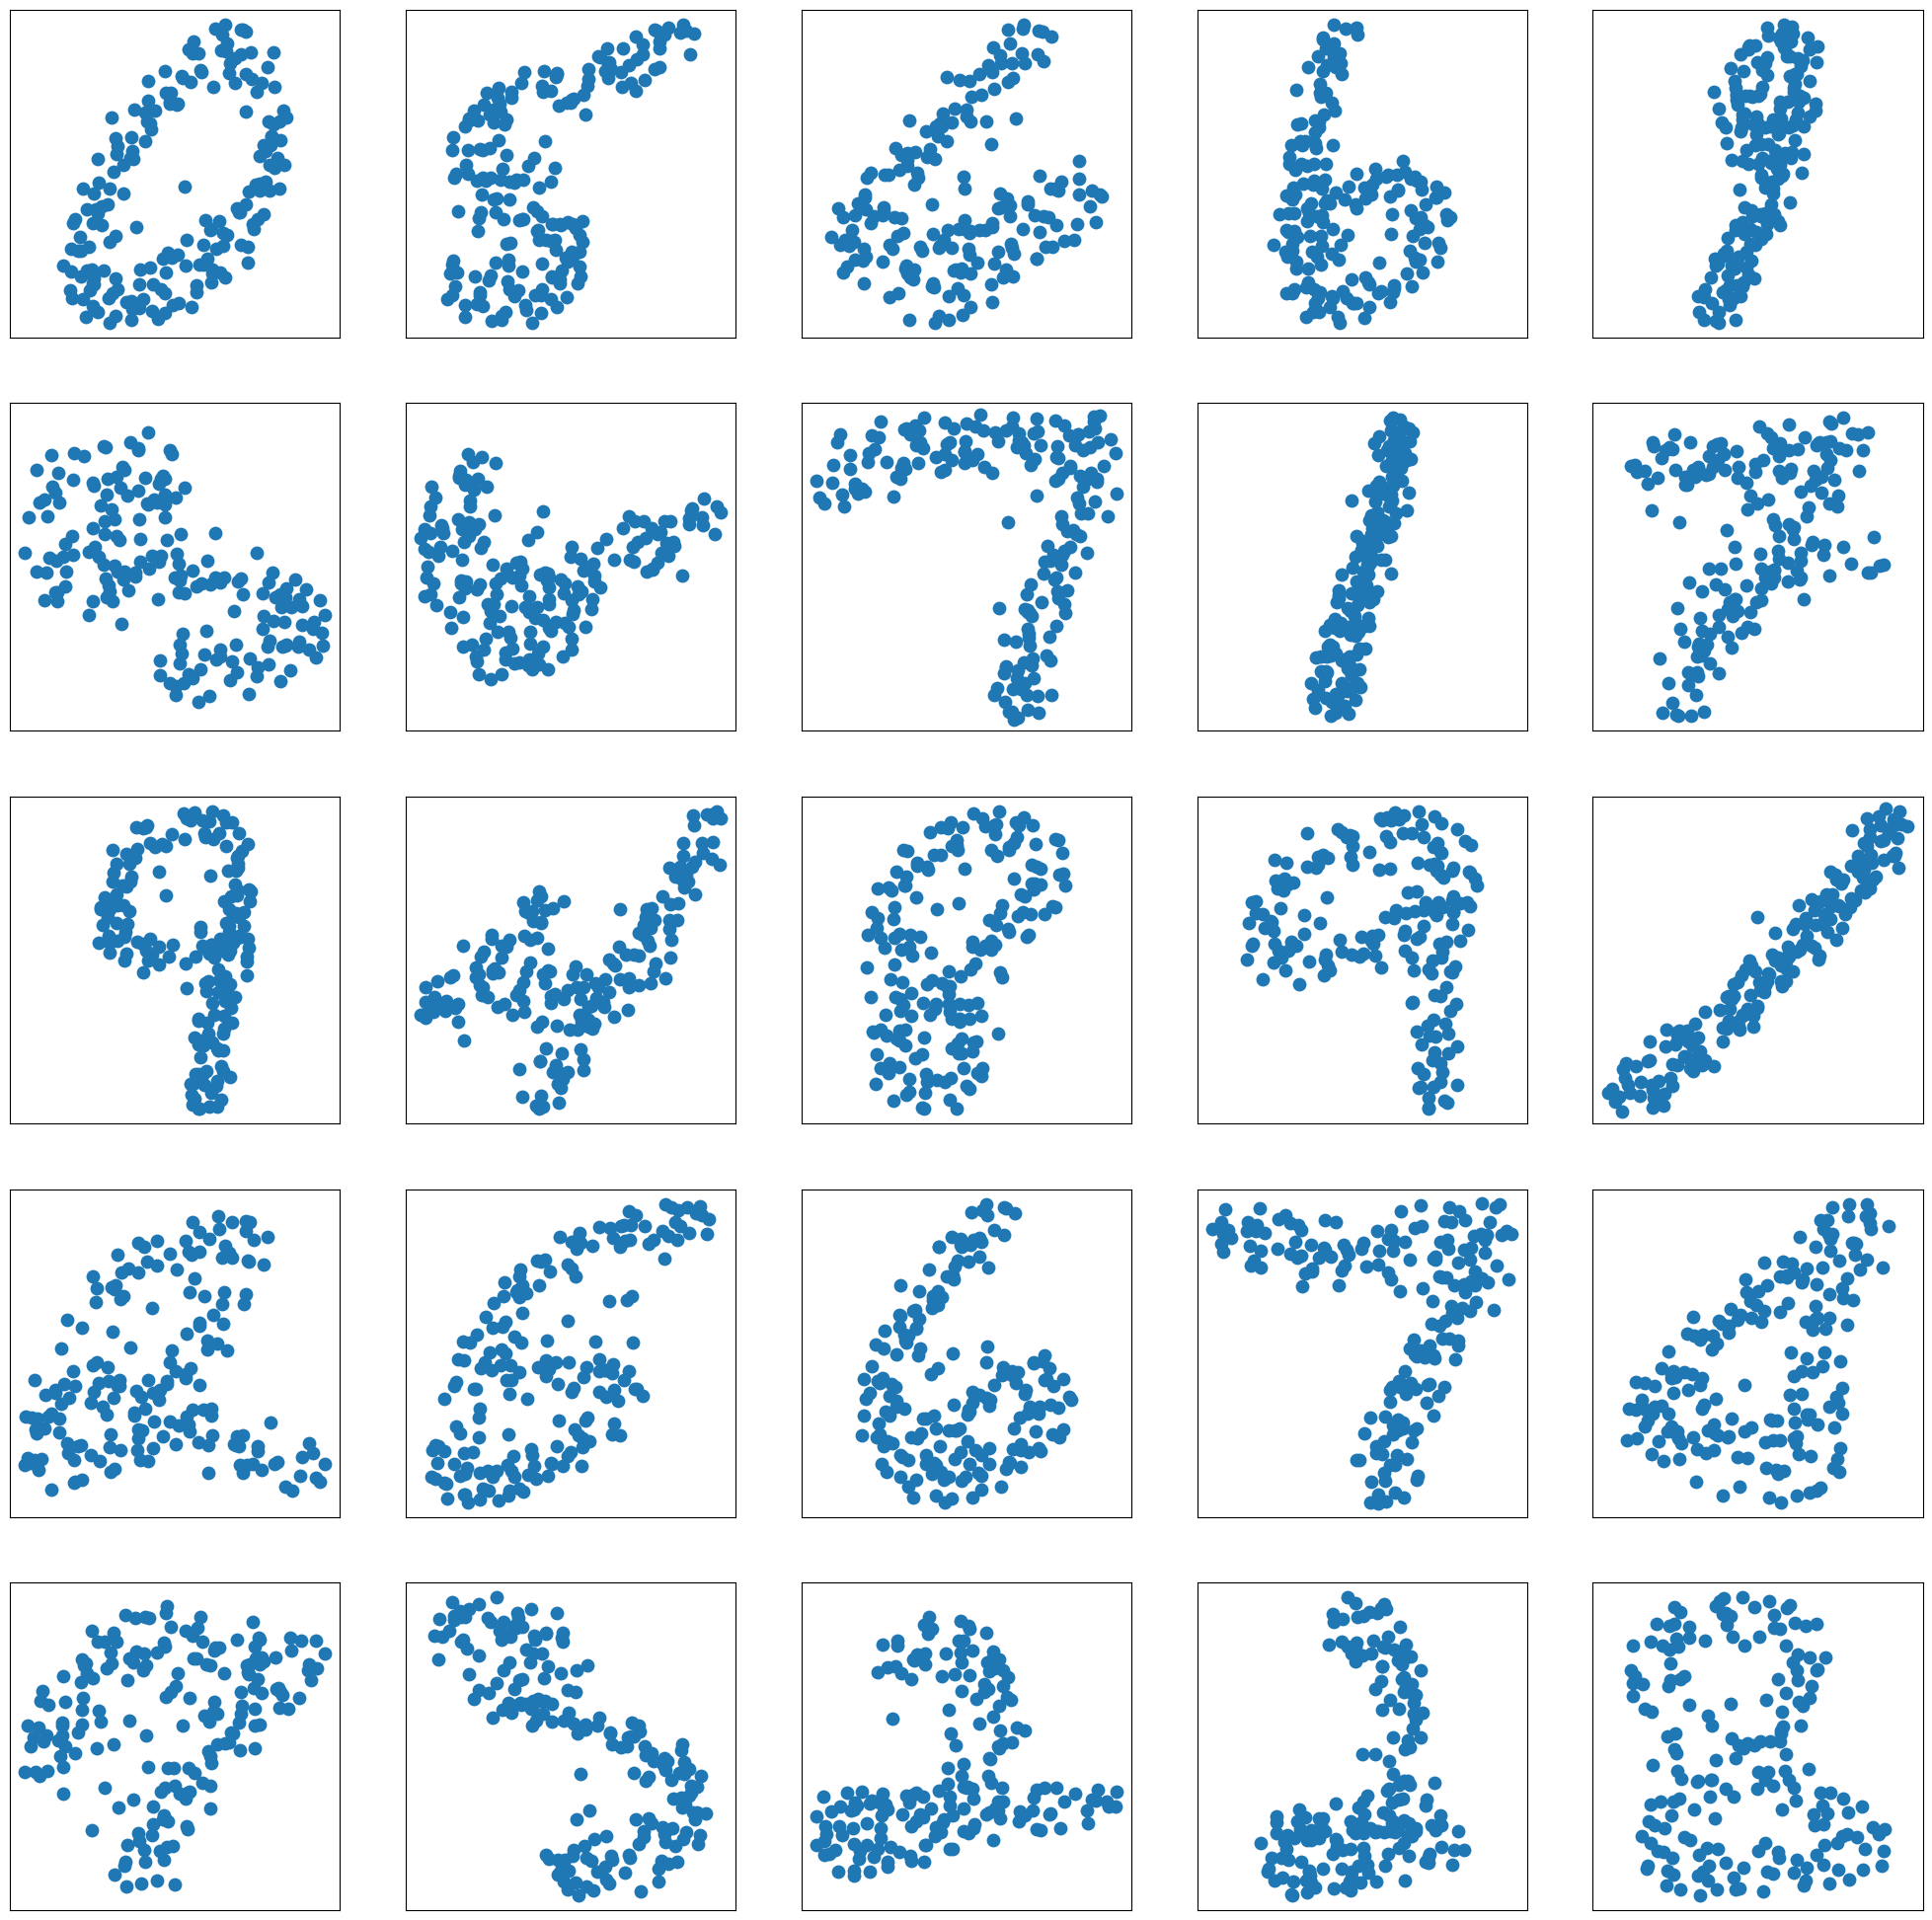

In [25]:
fig = plt.figure(figsize = (25,25))
for _ in range(25):
    ind = np.random.choice(np.arange(len(train_decodings)))
    
    plt.subplot(5,5,1+_)
    plt.scatter(train_decodings[ind][:, 1], -train_decodings[ind][:, 0], s = 80)
    plt.xticks([])
    plt.yticks([])
    plt.axis('equal')
plt.show()

### Plot test

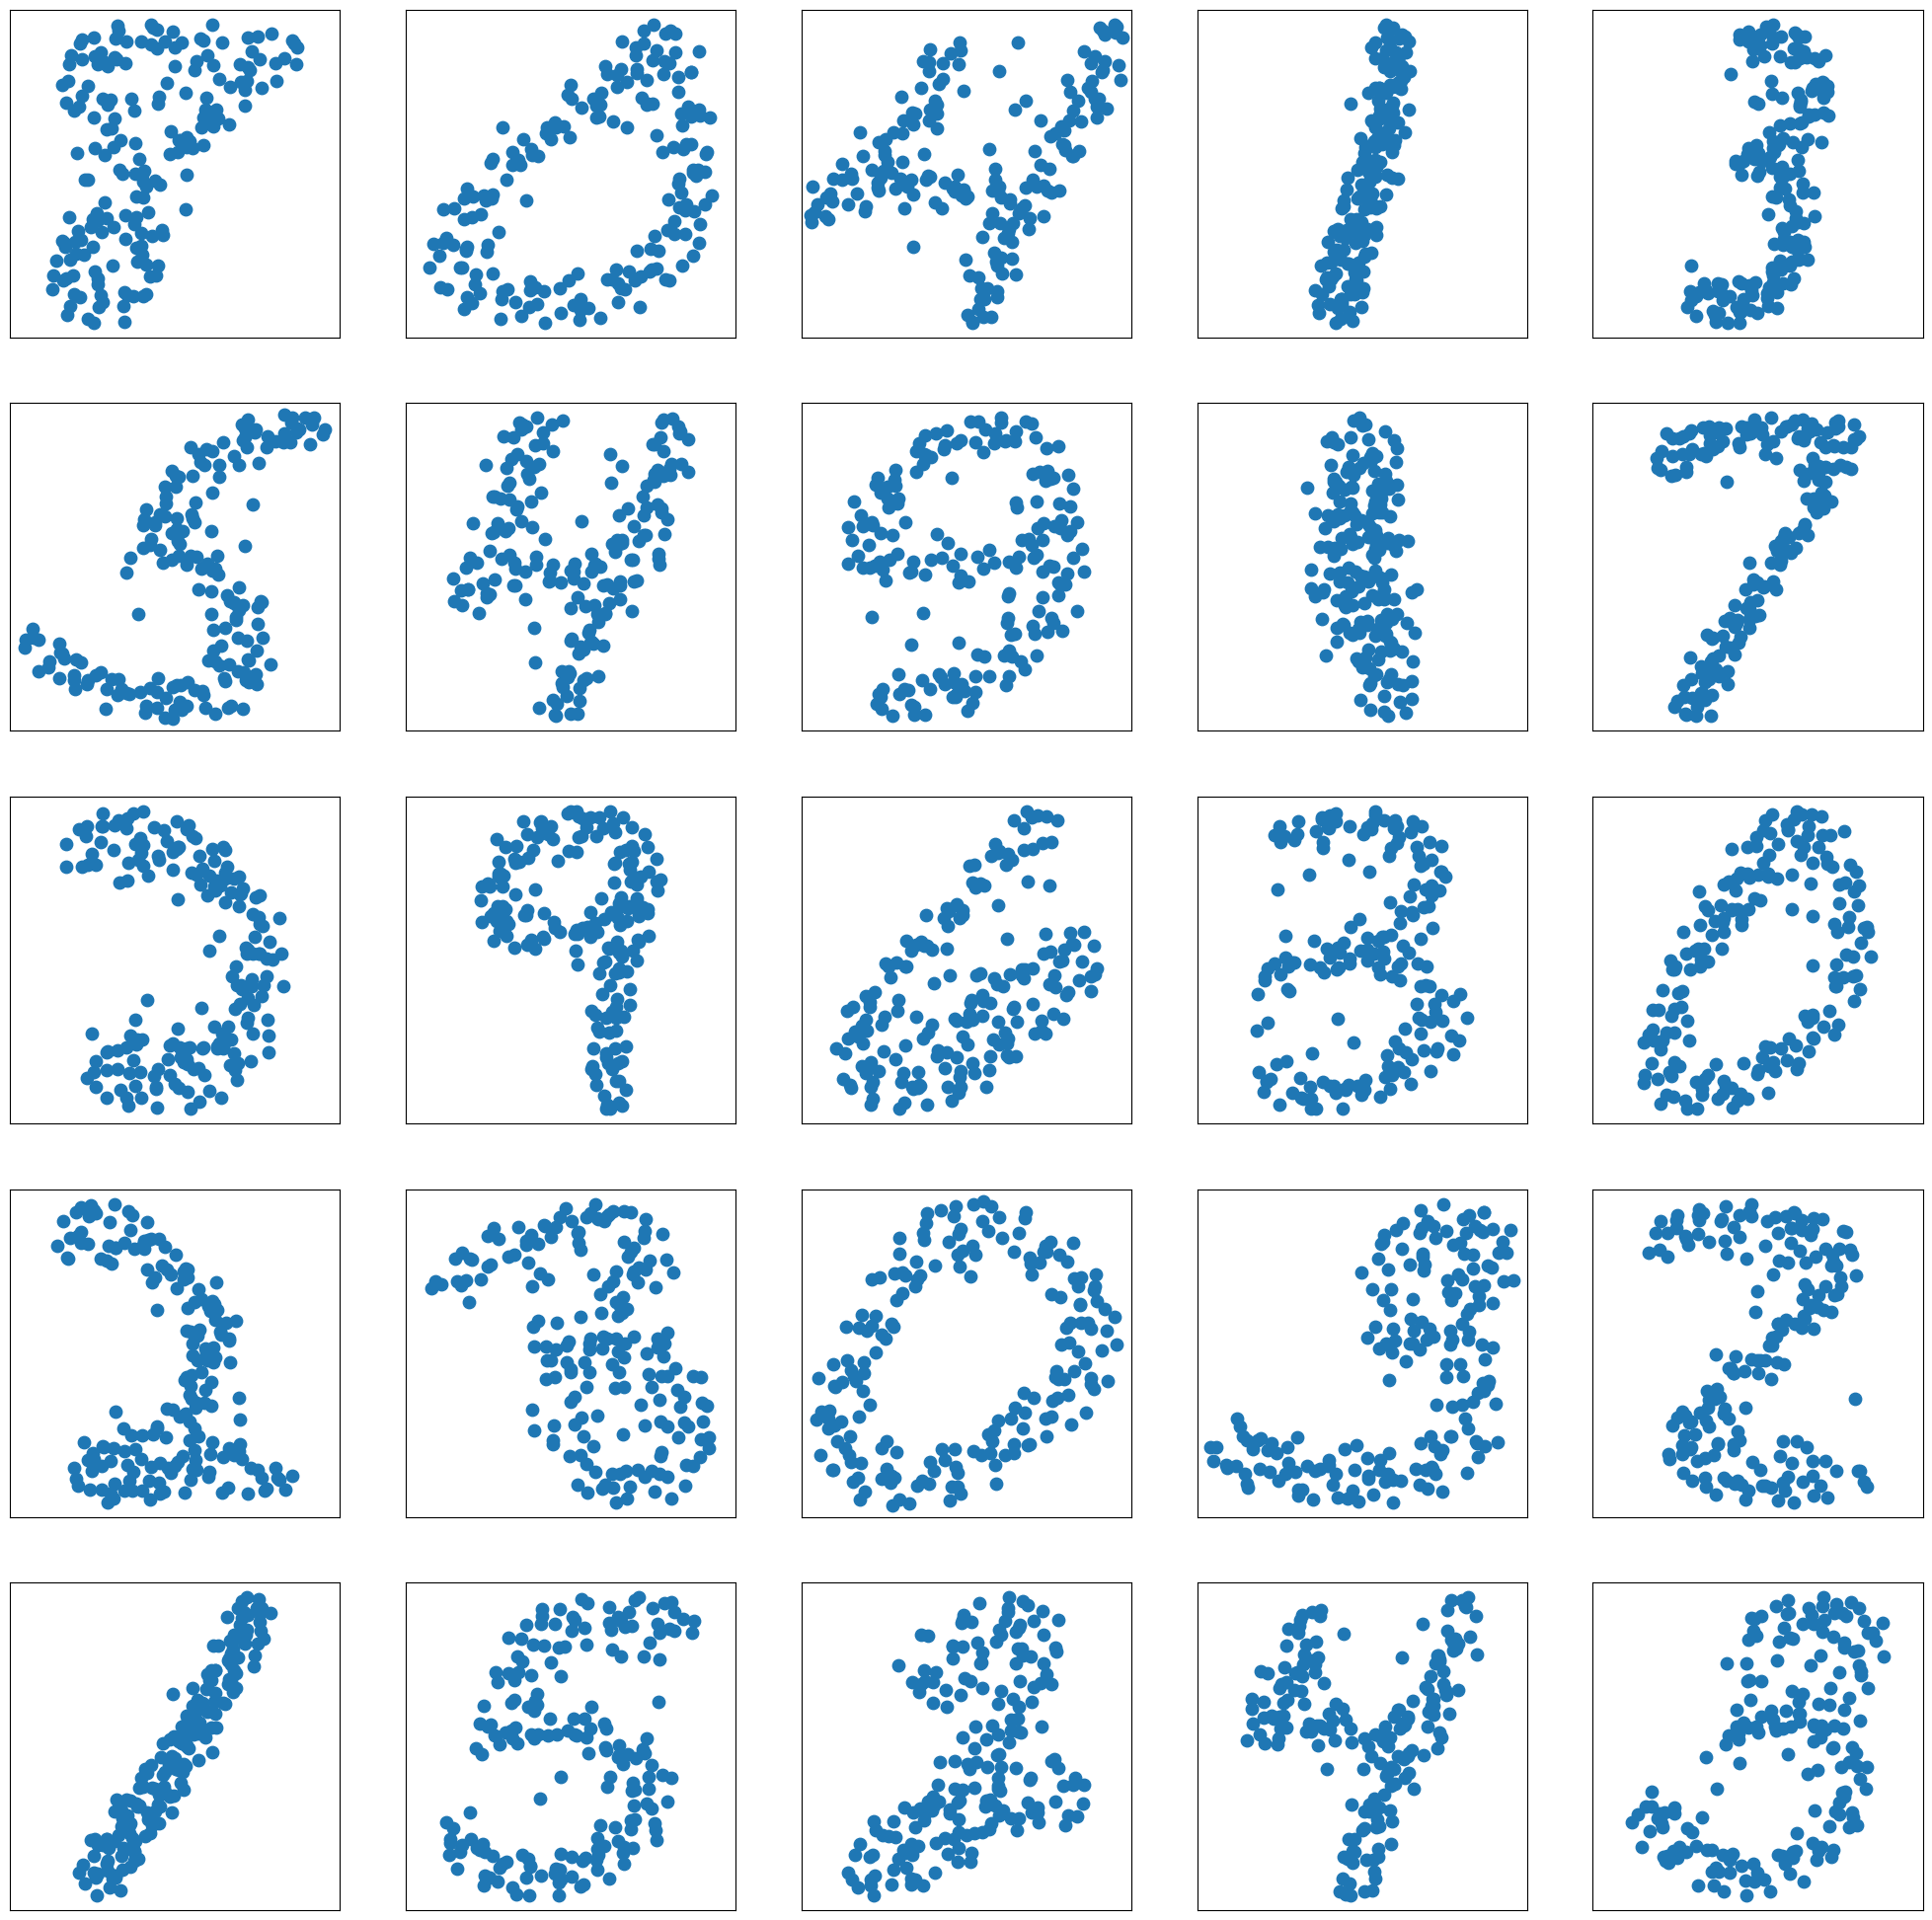

In [26]:
fig = plt.figure(figsize = (25,25))
for _ in range(25):
    ind = np.random.choice(np.arange(len(test_decodings)))
    
    plt.subplot(5,5,1+_)
    plt.scatter(test_decodings[ind][:, 1], -test_decodings[ind][:, 0], s = 80)
    plt.xticks([])
    plt.yticks([])
    plt.axis('equal')
plt.show()

### Barycenters

#### Calculate per-class encoding mean

In [27]:
class_encoding_mean = np.asarray([np.mean(train_encodings[label_train == digit], axis = 0) for digit in list(set(label_train))])

#### Decode for Wasserstein barycenters

In [28]:
class_barycenters = WormholeModel.decode(class_encoding_mean)

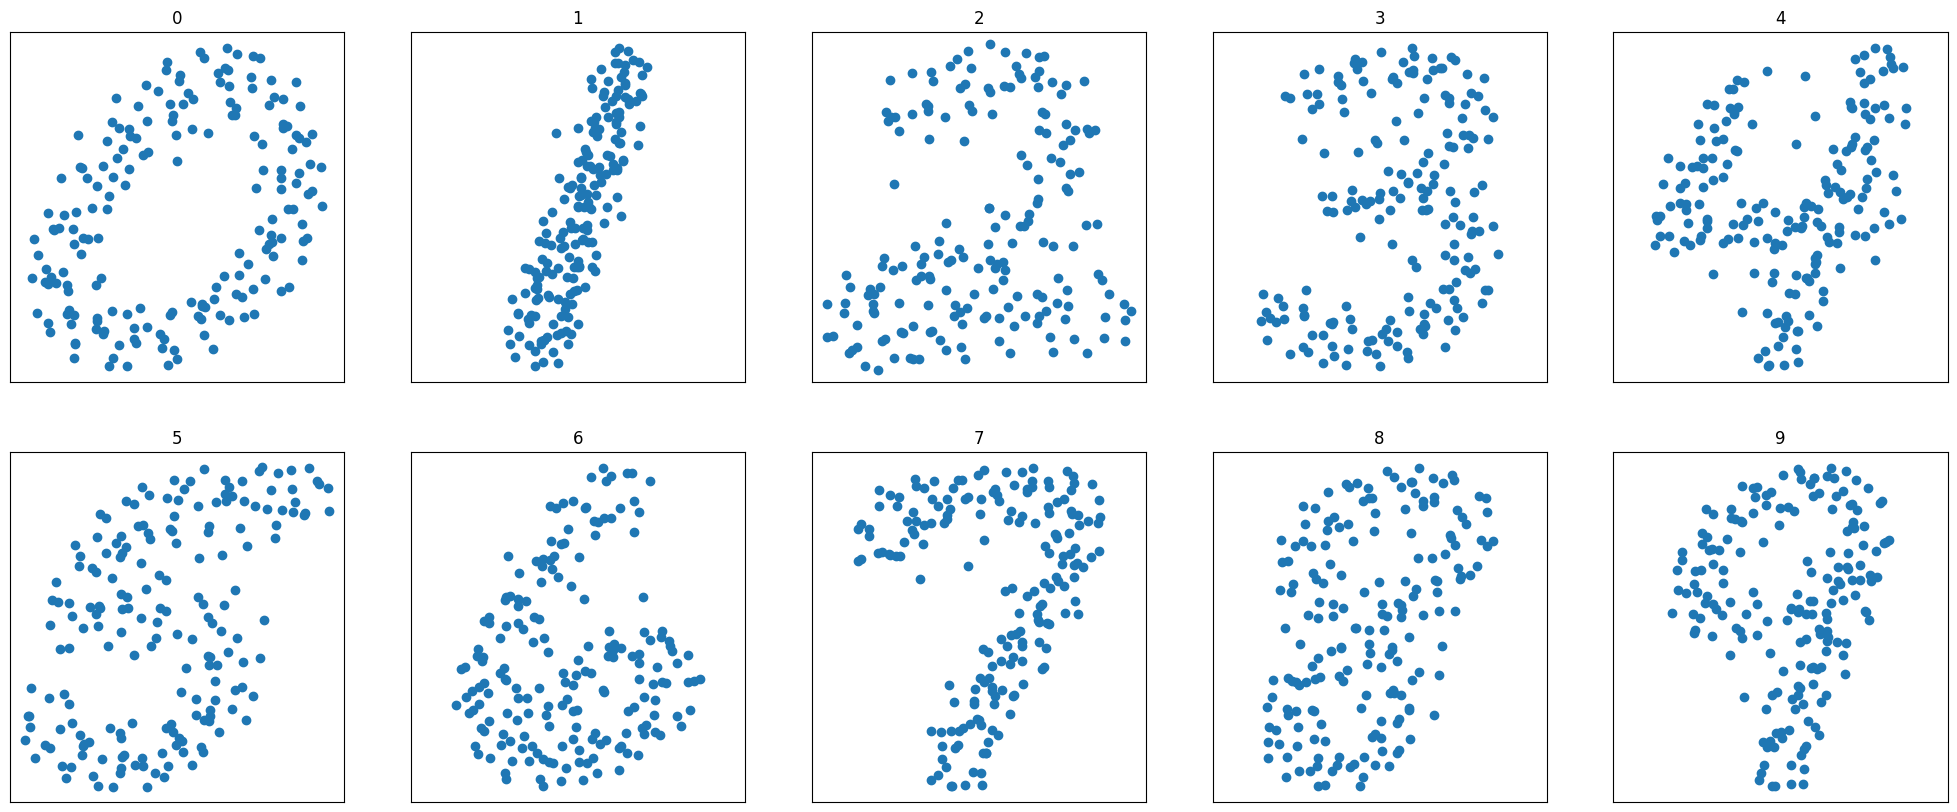

In [29]:
fig = plt.figure(figsize=(25, 10))
for i in list(set(label_train)):
    
    plt.subplot(2,5,1+i)
    plt.scatter(class_barycenters[i][:, 1], -class_barycenters[i][:, 0])
    plt.axis('equal')
    plt.xticks([])
    plt.yticks([])
    plt.title(i)
plt.show()


### Point Cloud Interpolation

#### Chooce start and end encodings

In [43]:
start_ind = np.random.randint(train_encodings.shape[0])
end_ind = np.random.randint(train_encodings.shape[0])

start_enc = train_encodings[start_ind]
end_enc = train_encodings[end_ind]


#### Linearly interpolate between them

In [44]:
interpolated_encodings = np.linspace(start_enc, end_enc, 8)

#### Decode interpolations

In [45]:
interpolated_decodings = WormholeModel.decode(interpolated_encodings)

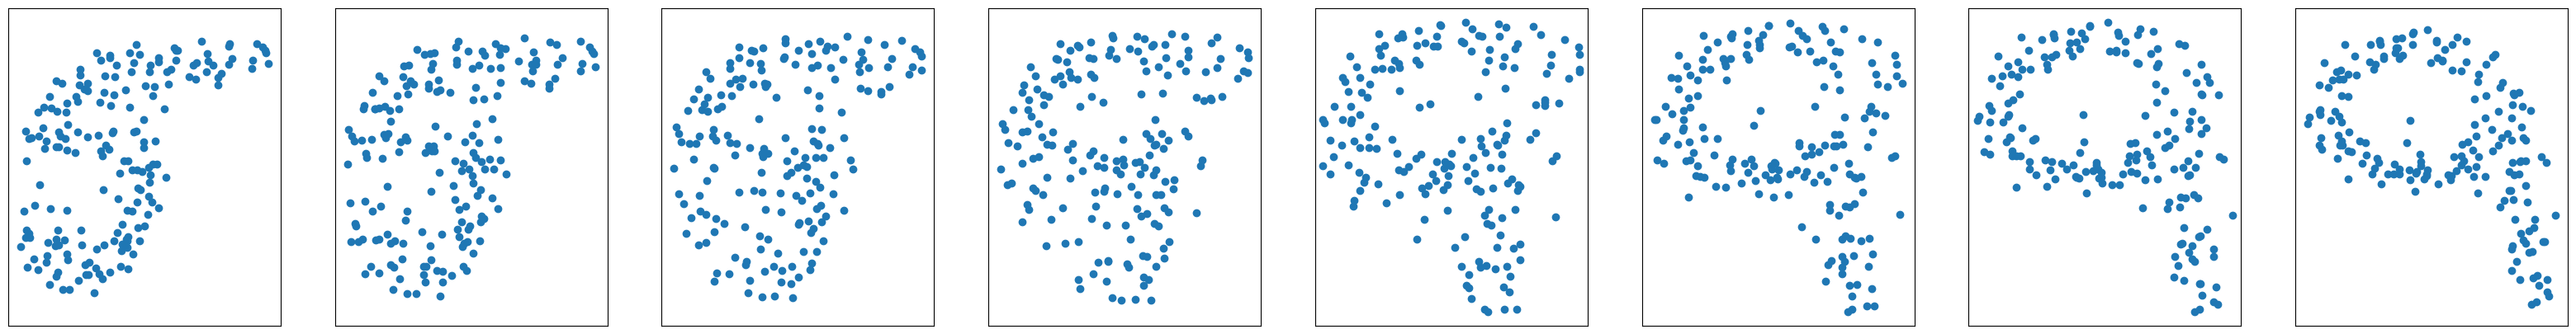

In [46]:
fig = plt.figure(figsize=(interpolated_decodings.shape[0]*5, 5))

    
for i in range(interpolated_decodings.shape[0]):
    
    plt.subplot(1,interpolated_decodings.shape[0],1+i)
    plt.scatter(interpolated_decodings[i][:, 1], -interpolated_decodings[i][:, 0])
    plt.axis('equal')
    plt.xticks([])
    plt.yticks([])
plt.show()

## Draw UMAPs

In [34]:
fit = umap.UMAP(
    n_neighbors = 30,
    min_dist = 0.01,
    n_components = 2,
)

umap = fit.fit_transform(np.concatenate([train_encodings, test_encodings], axis = 0))
umap_train =  umap[:train_encodings.shape[0]] 
umap_test =  umap[train_encodings.shape[0]:] 

In [35]:
cat_cmap = matplotlib.cm.get_cmap('cet_glasbey')
label_palette = {ctype:cat_cmap(i) for i,ctype in enumerate(list(set(label_train)))}

/tmp/ipykernel_1143224/2627742441.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cat_cmap = matplotlib.cm.get_cmap('cet_glasbey')


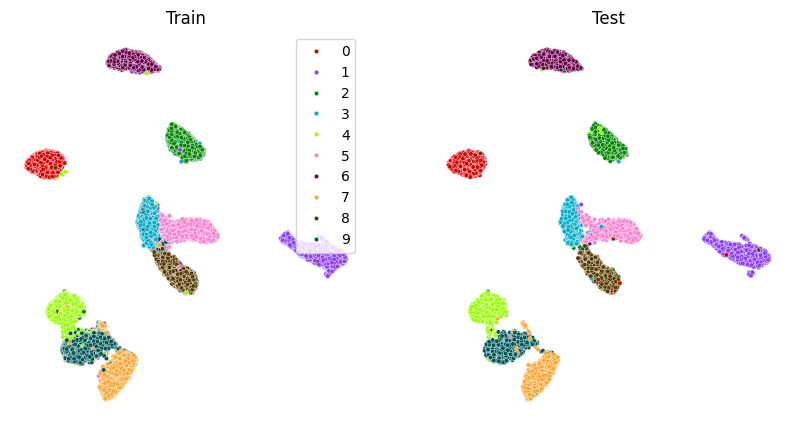

In [36]:
plt.figure(figsize=(10,5))

plt.subplot(121)
sns.scatterplot(x = umap_train[:, 0], 
                y = umap_train[:, 1], legend = True,
                hue = label_train, 
                s = 10, palette = label_palette)
plt.axis('off')
plt.title("Train")

plt.subplot(122 )
sns.scatterplot(x = umap_test[:, 0], 
                y = umap_test[:, 1], legend = False,
                hue = label_test, 
                s = 10, palette = label_palette)
plt.axis('off')
plt.title("Test")
plt.show()

## Classify Digits

In [37]:
classifier = sklearn.neural_network.MLPClassifier(max_iter=1000).fit(train_encodings, label_train)
test_predictions = classifier.predict(test_encodings)

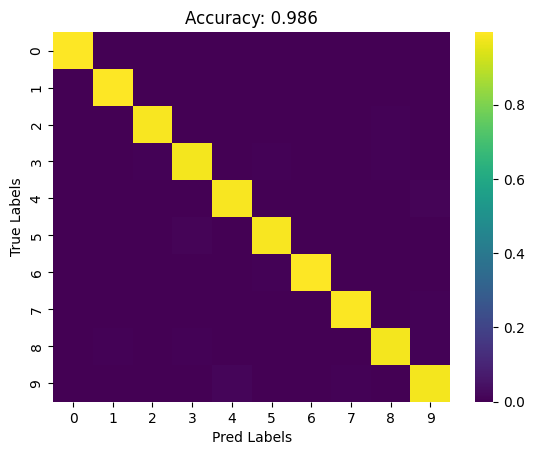

In [38]:
cm = pd.DataFrame(sklearn.metrics.confusion_matrix(label_test, test_predictions, labels=classifier.classes_, normalize = 'true'),
                  index = classifier.classes_, columns = classifier.classes_,)
sns.heatmap(cm, cmap = 'viridis')
plt.ylabel("True Labels")
plt.xlabel("Pred Labels")
plt.title("Accuracy: " + str(round(np.mean(label_test == test_predictions), 3)))
plt.show()